# Importing the libraries

In [111]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.metrics import f1_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import interp1d
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Defining a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Defining a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Creating a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Loading the data and feature engineering

In [7]:
# Reading the data and features from the pickle file saved in phase 2 notebook
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "2003_download/clean_data.pickle", "rb" ) )

In [8]:
## Creating the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data["loan_status"] == ('Charged Off' or "Default")

In [9]:
# Creating a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [10]:
# Randomly assigning each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## creating the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True,False],size = len(data),p=[.7,.3])

In [11]:
# Creating a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Preparing helper functions to fit and evaluate models

In [70]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Preparing the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [100]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                           model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred,"performance":f1_score(y_test, y_pred,average='weighted')}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Training and Testing different machine learning classification models


In [112]:
## feature selection based on phase 2
your_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb', 'cr_hist', 'train']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### DummyClassifier (Baseline)

  Model: Dummy Classifier
Fit time: 0.14 seconds
Optimal parameters:
{'strategy': 'most_frequent'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80395
              precision    recall  f1-score   support

  No default     0.8040    1.0000    0.8913     16079
     Default     0.0000    0.0000    0.0000      3921

    accuracy                         0.8040     20000
   macro avg     0.4020    0.5000    0.4457     20000
weighted avg     0.6463    0.8040    0.7166     20000



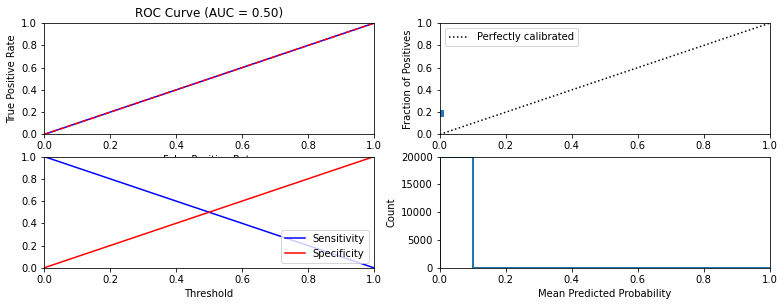


Similarity to LC grade ranking:  nan
Brier score: 0.19605
Were parameters on edge? : True
Score variations around CV search grid : 37.509866644509984
[0.80236667 0.80236667 0.68726667 0.5014            nan]


In [113]:
dummy_clf = DummyClassifier()
dummy=fit_classification(dummy_clf,data_dict,
                         cv_parameters = {'strategy': ["most_frequent", "prior", "stratified", "uniform", "constant"]},
                         model_name = 'Dummy Classifier')

### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 1.03 seconds
Optimal parameters:
{'var_smoothing': 1}

Accuracy-maximizing threshold was: 0.39119408294655195
Accuracy:  0.804
              precision    recall  f1-score   support

  No default     0.8043    0.9994    0.8913     16079
     Default     0.5238    0.0028    0.0056      3921

    accuracy                         0.8040     20000
   macro avg     0.6641    0.5011    0.4484     20000
weighted avg     0.7493    0.8040    0.7176     20000



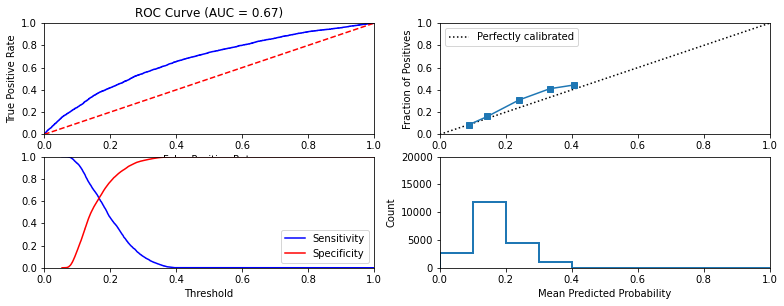


Similarity to LC grade ranking:  0.5913431556731094
Brier score: 0.15024007375297854
Were parameters on edge? : True
Score variations around CV search grid : 60.358938141331905
[0.31806667 0.5355     0.74406667 0.77026667 0.80236667]


In [49]:

gnb = GaussianNB()
gnb = fit_classification(gnb,data_dict,
                         cv_parameters = {'var_smoothing': [1e-10, 1e-5, 1e-3, 1e-1, 1]},
                         model_name = 'Gaussian Naive Bayes')

### $l_1$ regularized logistic regression

  Model: l_1 regularized logistic regression classifier
Fit time: 127.29 seconds
Optimal parameters:
{'C': 0.1, 'max_iter': 100}

Accuracy-maximizing threshold was: 0.4851972981709148
Accuracy:  0.805
              precision    recall  f1-score   support

  No default     0.8069    0.9958    0.8914     16079
     Default     0.5669    0.0227    0.0436      3921

    accuracy                         0.8050     20000
   macro avg     0.6869    0.5092    0.4675     20000
weighted avg     0.7598    0.8050    0.7252     20000



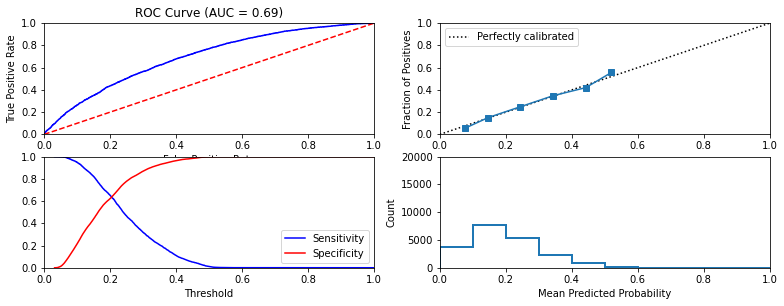


Similarity to LC grade ranking:  0.7762085980352409
Brier score: 0.14612249171148836
Were parameters on edge? : True
Score variations around CV search grid : 0.09550701768956399
[0.80236667 0.80236667 0.80236667 0.80273333 0.8027     0.80273333
 0.8021     0.80213333 0.80213333 0.80203333 0.80203333 0.80196667
 0.802      0.80203333 0.802     ]


In [51]:

l1_logistic = LogisticRegression(penalty='l1',solver = 'liblinear')
cv_parameters = {'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                 'max_iter': [100, 500, 1000]}

l1_logistic = fit_classification(l1_logistic,
                                 data_dict,
                                 cv_parameters =cv_parameters ,
                                 model_name ="l_1 regularized logistic regression classifier" )

### $l_2$ regularized logistic regression

  Model: l_2 regularized logistic regression classifier
Fit time: 28.13 seconds
Optimal parameters:
{'C': 0.01, 'max_iter': 100}

Accuracy-maximizing threshold was: 0.4677875888163105
Accuracy:  0.80415
              precision    recall  f1-score   support

  No default     0.8050    0.9981    0.8912     16079
     Default     0.5312    0.0087    0.0171      3921

    accuracy                         0.8042     20000
   macro avg     0.6681    0.5034    0.4542     20000
weighted avg     0.7514    0.8042    0.7199     20000



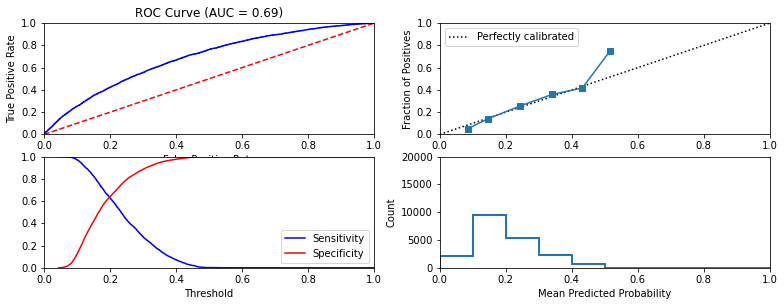


Similarity to LC grade ranking:  0.6751908257684053
Brier score: 0.147250921277263
Were parameters on edge? : True
Score variations around CV search grid : 0.08722741433020846
[0.8025     0.8025     0.8025     0.80246667 0.80246667 0.80246667
 0.80203333 0.80203333 0.80203333 0.8018     0.8023     0.8023
 0.8019     0.80226667 0.80226667]


In [52]:


l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                 'max_iter': [100, 500, 1000]}

l2_logistic = fit_classification(l2_logistic,
                                 data_dict,
                                 cv_parameters =cv_parameters ,
                                 model_name ="l_2 regularized logistic regression classifier" )

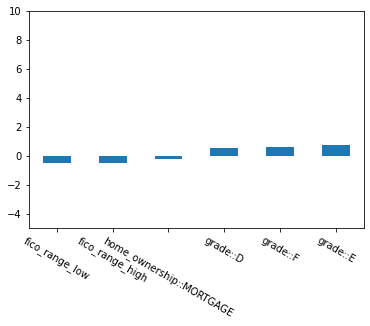

In [53]:
## plotting top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 17.05 seconds
Optimal parameters:
{'max_depth': 1.0}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80395
              precision    recall  f1-score   support

  No default     0.8040    1.0000    0.8913     16079
     Default     0.0000    0.0000    0.0000      3921

    accuracy                         0.8040     20000
   macro avg     0.4020    0.5000    0.4457     20000
weighted avg     0.6463    0.8040    0.7166     20000



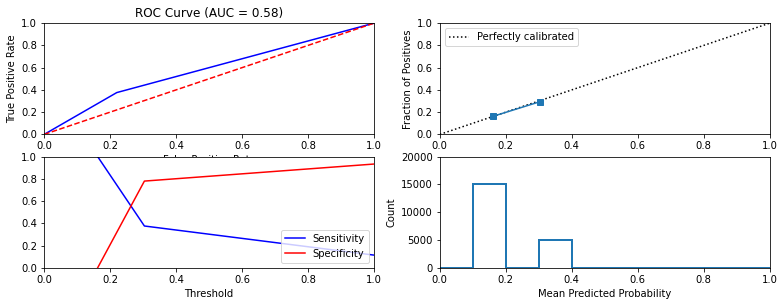


Similarity to LC grade ranking:  0.34812525840592184
Brier score: 0.15442823059127062
Were parameters on edge? : True
Score variations around CV search grid : 9.704623821195625
[0.80236667 0.80236667 0.80236667 0.8017     0.8001     0.79843333
 0.7971     0.79426667 0.78993333 0.7822     0.77843333 0.77126667
 0.76713333 0.7604     0.7529     0.74633333 0.7413     0.7329
 0.7271     0.7245    ]


In [54]:

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':np.linspace(1, 20, 20)}
data_dict = prepare_data(feature_subset = your_features)

decision_tree = fit_classification(decision_tree,data_dict,cv_parameters =cv_parameters ,model_name ="Decision Tree" )

### Random forest

  Model: Random Forest
Fit time: 502.37 seconds
Optimal parameters:
{'max_depth': 110, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.57
Accuracy:  0.80385
              precision    recall  f1-score   support

  No default     0.8050    0.9976    0.8910     16079
     Default     0.4865    0.0092    0.0180      3921

    accuracy                         0.8038     20000
   macro avg     0.6458    0.5034    0.4545     20000
weighted avg     0.7426    0.8038    0.7199     20000



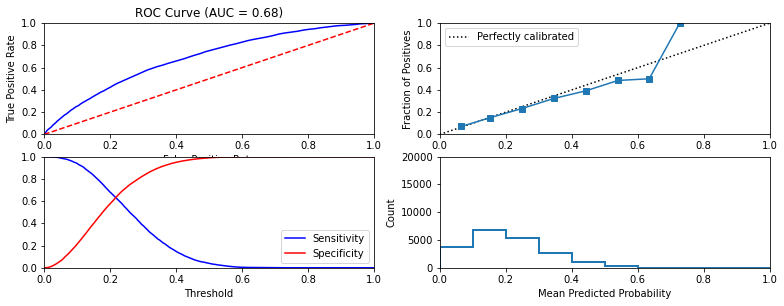


Similarity to LC grade ranking:  0.4798993594340665
Brier score: 0.14757652375
Were parameters on edge? : True
Score variations around CV search grid : 0.1458090318280265
[0.79973333 0.79896667 0.7995     0.79973333 0.7993     0.7994
 0.7999     0.79913333 0.79906667 0.7996     0.7992     0.799
 0.79966667 0.80013333 0.8        0.80003333]


In [55]:

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators': [100, 200, 300, 100],'max_depth': [80, 90, 100, 110]}
data_dict = prepare_data(feature_subset = your_features)
random_forest = fit_classification(random_forest,data_dict,cv_parameters =cv_parameters ,model_name ="Random Forest")

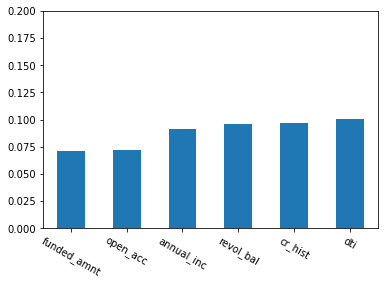

In [56]:
## Plotting top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

In [ ]:

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [20,40,60,80,100,120,140],'activation' : ['identity', 'logistic', 'tanh', 'relu'],'solver': ['lbfgs', 'sgd', 'adam'],'learning_rate' :['constant','adaptive']}
data_dict = prepare_data(feature_subset = your_features)
mlp = fit_classification(mlp,data_dict,cv_parameters =cv_parameters ,model_name ="Multi-layer perceptron")

  Model: Multi-layer perceptron
Fit time: 23.87 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5127940142210694
Accuracy:  0.8049
              precision    recall  f1-score   support

  No default     0.8081    0.9932    0.8911     16079
     Default     0.5401    0.0326    0.0616      3921

    accuracy                         0.8049     20000
   macro avg     0.6741    0.5129    0.4764     20000
weighted avg     0.7555    0.8049    0.7285     20000



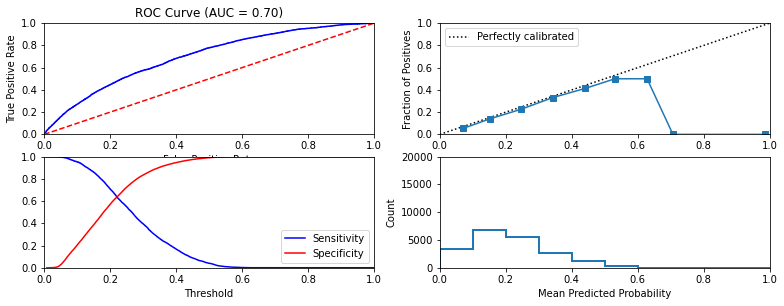


Similarity to LC grade ranking:  0.7546134776863364
Brier score: 0.14568840858428997
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80166667]


In [90]:
mlp_test= MLPClassifier(activation= 'identity', hidden_layer_sizes=100, learning_rate= 'constant', solver= 'adam')
data_dict = prepare_data(feature_subset = your_features)
mlp_1 = fit_classification(mlp_test,data_dict,model_name ="Multi-layer perceptron")

### KNN Classifier

  Model: KNN
Fit time: 110.57 seconds
Optimal parameters:
{'n_neighbors': 128}

Accuracy-maximizing threshold was: 0.46875
Accuracy:  0.8037
              precision    recall  f1-score   support

  No default     0.8047    0.9980    0.8910     16079
     Default     0.4576    0.0069    0.0136      3921

    accuracy                         0.8037     20000
   macro avg     0.6312    0.5024    0.4523     20000
weighted avg     0.7367    0.8037    0.7190     20000



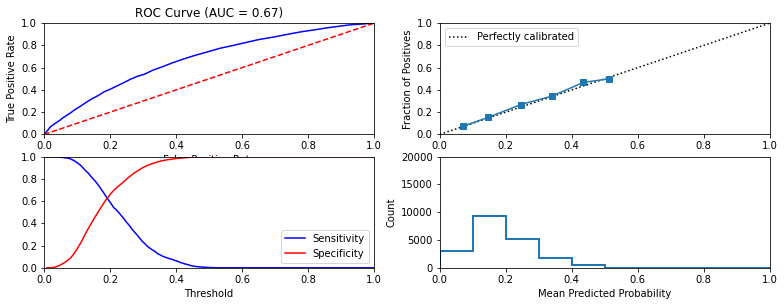


Similarity to LC grade ranking:  0.664142000201902
Brier score: 0.14863171997070312
Were parameters on edge? : True
Score variations around CV search grid : 12.600224336338327
[0.70126667 0.78073333 0.78576667 0.7928     0.79643333 0.80053333
 0.80233333 0.80236667]


In [59]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
cv_parameters = {'n_neighbors':[1,2,4,8,16,32,64,128]}
data_dict = prepare_data(feature_subset = your_features)
knn = fit_classification(KNN,data_dict,cv_parameters =cv_parameters ,model_name ="KNN")

## AdaBoost

  Model: AdaBoost classifier
Fit time: 62.84 seconds
Optimal parameters:
{'n_estimators': 30}

Accuracy-maximizing threshold was: 0.5025949258013708
Accuracy:  0.80345
              precision    recall  f1-score   support

  No default     0.8050    0.9971    0.8908     16079
     Default     0.4390    0.0092    0.0180      3921

    accuracy                         0.8034     20000
   macro avg     0.6220    0.5032    0.4544     20000
weighted avg     0.7332    0.8034    0.7197     20000



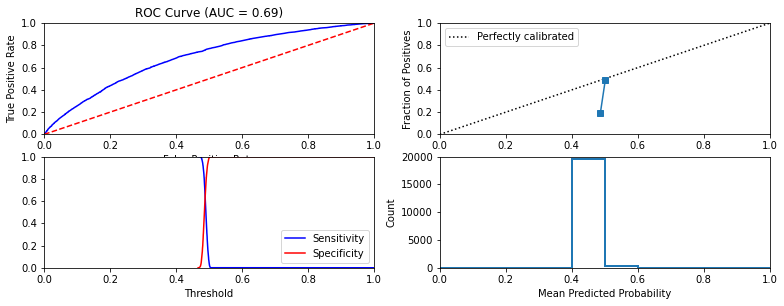


Similarity to LC grade ranking:  0.630887412101829
Brier score: 0.24093426326040435
Were parameters on edge? : False
Score variations around CV search grid : 0.10809462437115458
[0.80136667 0.80116667 0.80176667 0.8012     0.80163333 0.80113333
 0.8009     0.80096667]


In [79]:
ada_clf=AdaBoostClassifier()
cv_parameters = {'n_estimators': [10,20,30,40,50,60,70,100]}
data_dict = prepare_data(feature_subset = your_features)
ada = fit_classification(ada_clf,
                         data_dict,
                         cv_parameters =cv_parameters ,
                         model_name ="AdaBoost classifier" )

## Training and Testing logistic regression model with feature (grade)  derived by LendingClub

In [50]:
random_state=[i for i in range(100)]

In [101]:
a_lendingclub_feature = 'grade'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1',solver = 'liblinear')
cv_parameters = {'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                 'max_iter': [100, 500, 1000]}
performance=[]
for i in random_state:
    lc1_l1 = fit_classification(lc1_only_logistic,
                                 data_dict,
                                 cv_parameters=cv_parameters,
                                 random_state = i,
                                 output_to_file = False,
                                 print_to_screen = False,
                                 model_name ="l_1 regularized logistic regression classifier with LC derived feature" )
    performance.append(lc1_l1['performance'])

avg_perf=np.average(performance)
sd=np.std(performance)
print("Average performance +- std of L1 Logistic regression with LC derived feature:",avg_perf+sd,avg_perf-sd)
    
    

Average performance +- std of L1 Logistic regression with LC derived feature: 0.7165781784417529 0.7165781784417529


In [102]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                 'max_iter': [100, 500, 1000]}
performance=[]
for i in random_state:
    lc2_l2 = fit_classification(lc2_only_logistic,
                                       data_dict,
                                       cv_parameters=cv_parameters,
                                       random_state=i,
                                       output_to_file=False,
                                       print_to_screen=False,
                                       model_name ="l_2 regularized logistic regression classifier with LC derived feature" )
    performance.append(lc2_l2['performance'])
avg_perf=np.average(performance)
sd=np.std(performance)
print("Average performance +- std of L2 Logistic regression with LC derived feature:",avg_perf+sd,avg_perf-sd)

Average performance +- std of L2 Logistic regression with LC derived feature: 0.7165781784417529 0.7165781784417529


## Train and test all the models after removing grade feature 

In [103]:
your_features_grade_removed = ['loan_amnt', 'funded_amnt', 'term', 'int_rate',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb', 'cr_hist', 'train']
# removed grade
data_dict = prepare_data(feature_subset = your_features_grade_removed)
gnb_performance=[]
l1_performance=[]
l2_performance=[]
decision_tree_performance=[]
rf_performance=[]
mlp_performance=[]
ada_performance=[]

for i in random_state:

    #NB
    gnb = GaussianNB(var_smoothing= 1)
    gnb_obj = fit_classification(gnb,
                             data_dict,
                             random_state=i,
                             output_to_file=False,
                             print_to_screen=False,
                             model_name = 'Gaussian Naive Bayes')
    gnb_performance.append(gnb_obj['performance'])

    #l1 logistic
    l1_logistic = LogisticRegression(penalty='l1',solver = 'liblinear',C=0.1, max_iter=100)

    l1_logistic_obj = fit_classification(l1_logistic,
                                 data_dict,
                                 random_state=i,
                                 output_to_file=False,
                                 print_to_screen=False,
                                 model_name ="l_1 regularized logistic regression classifier" )
    l1_performance.append(l1_logistic_obj['performance'])

    #l2 logistic
    l2_logistic = LogisticRegression(penalty='l2',C=0.01, max_iter= 100)

    l2_logistic_obj = fit_classification(l2_logistic,
                                 data_dict,
                                 random_state=i,
                                 output_to_file=False,
                                 print_to_screen=False,
                                 model_name ="l_2 regularized logistic regression classifier" )
    l2_performance.append(l2_logistic_obj['performance'])

    #Decision tree
    decision_tree = DecisionTreeClassifier(max_depth= 1.0)
    decision_tree_obj= fit_classification(decision_tree,
                                          data_dict ,
                                          random_state=i,
                                          output_to_file=False,
                                          print_to_screen=False,
                                          model_name ="Decision Tree" )
    decision_tree_performance.append(decision_tree_obj['performance'])

    #RandomForest
    random_forest = RandomForestClassifier(max_depth= 100, n_estimators= 200)
    random_forest_obj = fit_classification(random_forest,
                                           data_dict,
                                           random_state=i,
                                           output_to_file=False,
                                           print_to_screen=False,
                                           model_name ="Random Forest")
    rf_performance.append(random_forest_obj['performance'])

    #MLP
    mlp = MLPClassifier(activation='identity', hidden_layer_sizes=60, learning_rate='constant', solver= 'sgd')
    mlp_obj = fit_classification(mlp,
                                 data_dict,
                                 random_state=i,
                                 output_to_file=False,
                                 print_to_screen=False,
                                 model_name ="Multi-layer perceptron")
    mlp_performance.append(mlp_obj['performance'])

    #Adaboost
    ada_clf=AdaBoostClassifier(n_estimators= 10)
    ada = fit_classification(ada_clf,
                             data_dict,
                             random_state=i,
                             output_to_file=False,
                             print_to_screen=False,
                             model_name ="AdaBoost classifier" )
    ada_performance.append(ada['performance'])
    
print("Average performance +- std of Gaussian NB classifier without LC derived feature:",np.average(gnb_performance)+np.std(gnb_performance),np.average(gnb_performance)-np.std(gnb_performance))
print("Average performance +- std of L1 Logistic Regression without LC derived feature:",np.average(l1_performance)+np.std(l1_performance),np.average(l1_performance)-np.std(l2_performance))
print("Average performance +- std of L2 Logistic Regression without LC derived feature:",np.average(l2_performance)+np.std(l2_performance),np.average(l2_performance)-np.std(l2_performance))
print("Average performance +- std of Decision Tree classifier without LC derived feature:",np.average(decision_tree_performance)+np.std(decision_tree_performance),np.average(decision_tree_performance)-np.std(decision_tree_performance))
print("Average performance +- std of Random classifier without LC derived feature:",np.average(rf_performance)+np.std(rf_performance),np.average(rf_performance)-np.std(rf_performance))
print("Average performance +- std of MLP classifier without LC derived feature:",np.average(mlp_performance)+np.std(mlp_performance),np.average(mlp_performance)-np.std(mlp_performance))
print("Average performance +- std of AdaBoost classifier without LC derived feature:",np.average(ada_performance)+np.std(ada_performance),np.average(ada_performance)-np.std(ada_performance))




Average performance +- std of Gaussian NB classifier without LC derived feature: 0.7179318482238959 0.7179318482238957
Average performance +- std of L1 Logistic Regression without LC derived feature: 0.7200933105064655 0.7200551986529892
Average performance +- std of L2 Logistic Regression without LC derived feature: 0.7187308907190054 0.7187308907190048
Average performance +- std of Decision Tree classifier without LC derived feature: 0.7165781784417529 0.7165781784417529
Average performance +- std of Random classifier without LC derived feature: 0.7199138126769689 0.7179140588273736
Average performance +- std of MLP classifier without LC derived feature: 0.7210555402547913 0.7178019790772292
Average performance +- std of AdaBoost classifier without LC derived feature: 0.7166980148598092 0.716698014859809


**it is surprising to see that we get very similar average performances for all the models as before.**

### Choosing l1 regularized logistic regression as the classifier of choice due to the best weighter average f1 score

  Model: L1 Logistic Regression
Fit time: 1.37 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.47391067214243765
Accuracy:  0.80415
              precision    recall  f1-score   support

  No default     0.8051    0.9980    0.8912     16079
     Default     0.5294    0.0092    0.0180      3921

    accuracy                         0.8042     20000
   macro avg     0.6672    0.5036    0.4546     20000
weighted avg     0.7510    0.8042    0.7200     20000



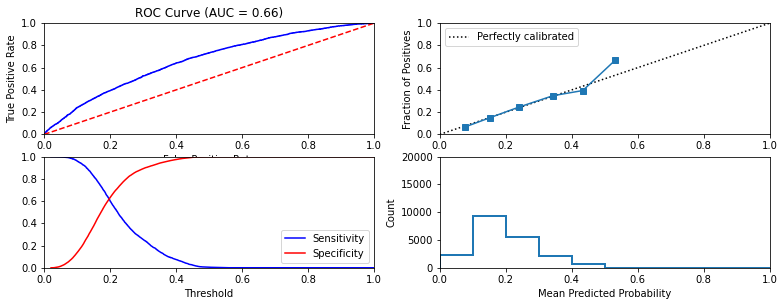


Similarity to LC grade ranking:  0.46621070267103637
Brier score: 0.14932006726304217
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80246667]


In [106]:
l1_logistic = LogisticRegression(penalty='l1',solver = 'liblinear',C=0.1, max_iter=100)
data_dict = prepare_data(feature_subset = your_features_grade_removed)
l1_logistic_reg = fit_classification(l1_logistic,
                         data_dict,
                         model_name ="L1 Logistic Regression" )


# Time stability test of l1 regularized logistic regression

  Model: L1 logistic regression on 2010 data
Fit time: 0.09 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7868571428571428
              precision    recall  f1-score   support

  No default     0.7869    1.0000    0.8807      5508
     Default     0.0000    0.0000    0.0000      1492

    accuracy                         0.7869      7000
   macro avg     0.3934    0.5000    0.4404      7000
weighted avg     0.6191    0.7869    0.6930      7000



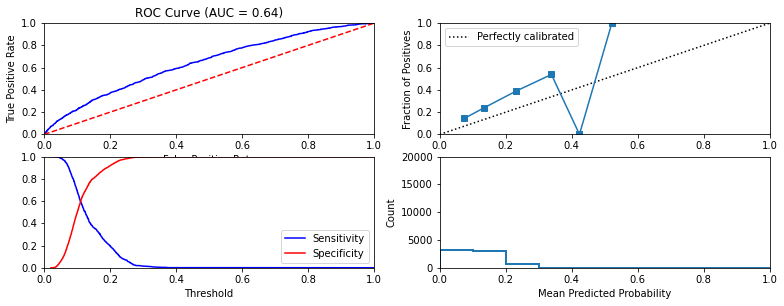


Similarity to LC grade ranking:  0.5633467949085471
Brier score: 0.17015676757739973
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.88557143]


In [108]:
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2010, 12, 31)
start_date_test = datetime.date(2018, 1, 1)
end_date_test = datetime.date(2018, 12, 1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
l1_logistic = LogisticRegression(penalty='l1',solver = 'liblinear',C=0.1, max_iter=100)
l1_2010 = fit_classification(l1_logistic,
                         data_dict_test,
                         model_name ="L1 logistic regression on 2010 data" )

  Model: L1 logistic regression on 2017 data
Fit time: 0.31 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7792857142857142
              precision    recall  f1-score   support

  No default     0.7793    1.0000    0.8760      5455
     Default     0.0000    0.0000    0.0000      1545

    accuracy                         0.7793      7000
   macro avg     0.3896    0.5000    0.4380      7000
weighted avg     0.6073    0.7793    0.6826      7000



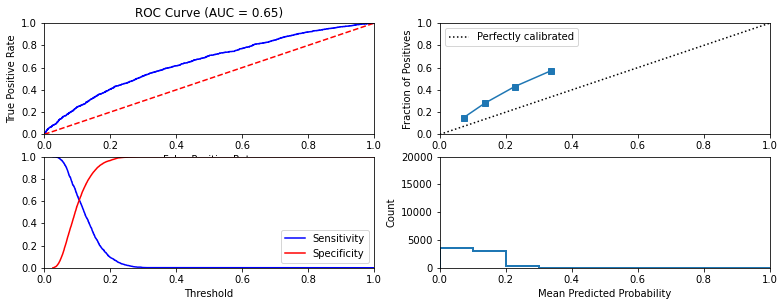


Similarity to LC grade ranking:  0.4915290697791847
Brier score: 0.17798739502487057
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.885]


In [109]:
start_date_train = datetime.date(2017, 1, 1)
end_date_train = datetime.date(2017, 12, 1)
start_date_test = datetime.date(2018, 1, 1)
end_date_test = datetime.date(2018, 12, 1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
l1_logistic = LogisticRegression(penalty='l1',solver = 'liblinear',C=0.1, max_iter=100)
l1_2017 = fit_classification(l1_logistic,
                         data_dict_test,
                         model_name ="L1 logistic regression on 2017 data" )

## Building regression models to predict the average return on investment

In [20]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Traininf two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [30]:
reg_lasso = linear_model.Lasso()
cv_parameters = {'alpha': [0.01, 0.1, 1, 10]}
data_dict = prepare_data(feature_subset = your_features)
reg_lasso = fit_regression(reg_lasso ,data_dict, 
                           cv_parameters = cv_parameters ,
                           model_name = '𝑙1 regularized linear regression',output_to_file=False )

  Model: 𝑙1 regularized linear regression  Return column: ret_PESS
Fit time: 0.4 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.07083962426978796
  Model: 𝑙1 regularized linear regression  Return column: ret_OPT
Fit time: 0.51 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.009382578195717528
  Model: 𝑙1 regularized linear regression  Return column: ret_INTa
Fit time: 0.41 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.0032362051697140126
  Model: 𝑙1 regularized linear regression  Return column: ret_INTb
Fit time: 0.52 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.015076960889027768


### $l_2$ regularized linear regressor

In [31]:
## trying l2 regularized linear regression with hyper-parameters
reg_ridge = linear_model.Ridge()
cv_parameters = {'alpha': [0.01, 0.1, 1, 10]}
data_dict = prepare_data(feature_subset = your_features)
reg_ridge = fit_regression(reg_ridge ,data_dict, 
                           cv_parameters = cv_parameters ,
                           model_name = '𝑙2 regularized linear regression',output_to_file=False )

  Model: 𝑙2 regularized linear regression  Return column: ret_PESS
Fit time: 0.29 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.09842640063162755
  Model: 𝑙2 regularized linear regression  Return column: ret_OPT
Fit time: 0.3 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.016045031052308478
  Model: 𝑙2 regularized linear regression  Return column: ret_INTa
Fit time: 0.31 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.034345931300323596
  Model: 𝑙2 regularized linear regression  Return column: ret_INTb
Fit time: 0.29 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.031026826406505226


### Multi-layer perceptron regressor

In [85]:
## trying multi-layer perceptron regression with hyper-parameters

mlp_reg = MLPRegressor()
cv_parameters = {'activation':['identity','relu','logistic'],'alpha':[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02]}
data_dict = prepare_data(feature_subset = your_features)
mlp_reg = fit_regression(mlp_reg, data_dict, cv_parameters=cv_parameters, model_name = "Multi-layer Perceptron Regression")

  Model: Multi-layer Perceptron Regression  Return column: ret_PESS
Fit time: 23802.14 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001}

Testing r2 score: 0.09597736962079473
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -416.43894132713825
All test scores : [-0.07515327 -0.08168165 -0.07364349 -0.05760354 -0.09539033 -0.14602688
 -0.20395093 -0.19254868 -0.14749664 -0.14351257 -0.04086383 -0.09434788
 -0.03949178 -0.10674466 -0.04662987]
  Model: Multi-layer Perceptron Regression  Return column: ret_OPT
Fit time: 10116.86 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.01}

Testing r2 score: 0.01644052178309685
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -172.172692251619
All test scores : [-0.12108852 -0.15310054 -0.13407921 -0.1276937  -0.10883138 -0.25504366
 -0.29620931 -0.27475103 -0.28104524 -0.26389253 -0.12913617 -0.12796423
 -0.12812705 -0.15446004 -0

### Random forest regressor

In [86]:
## trying random forest regression with hyper-parameters
rf = RandomForestRegressor()
cv_parameters = {'max_depth': [80, 90, 100, 110],'max_features': [2, 3],'min_samples_leaf': [3, 4, 5],'min_samples_split': [8, 10, 12],'n_estimators': [100, 200, 300]}
data_dict = prepare_data(feature_subset = your_features)
reg_rf = fit_regression(rf, data_dict=data_dict, cv_parameters=cv_parameters,model_name = "Random Forest Regression")

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 2736.61 seconds
Optimal parameters:
{'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}

Testing r2 score: 0.10537891643691144
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -24.183237018039183
All test scores : [-0.08059741 -0.07862441 -0.07926844 -0.0796374  -0.08062172 -0.07816915
 -0.08041898 -0.07903626 -0.07911791 -0.08274852 -0.08218663 -0.08197827
 -0.08285717 -0.07808129 -0.08127953 -0.08316301 -0.0810781  -0.08094868
 -0.0835796  -0.08178095 -0.081344   -0.08297552 -0.08321686 -0.08254985
 -0.08379863 -0.08158935 -0.0825657  -0.07089544 -0.07072853 -0.06859701
 -0.07164524 -0.06997048 -0.06824871 -0.07114041 -0.06968568 -0.06930987
 -0.07261955 -0.07025543 -0.07011256 -0.07130601 -0.07135942 -0.07133094
 -0.07205519 -0.07088328 -0.07024227 -0.07129255 -0.07129044 -0.0720792
 -0.07152432 -0.07043435 -0.07065723 -0.0

**We are going to use Ridge Regression as our model of choice to predict the return on a loan**

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [27]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [32]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)
#rf = RandomForestRegressor('max_depth'= 80, 'max_features'= 3, 'min_samples_leaf'= 3, 'min_samples_split'= 10, 'n_estimators'=300)
strat_rand = test_investments(data_dict=data_dict,classifier=None,regressor=None,strategy = test_strategy,num_loans = 1000,random_state = default_seed,
                        output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.2917708633472365
ret_OPT: 1.4209333545848566
ret_INTa: 0.4229711403316782
ret_INTb: 1.254544870120364


In [34]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict=data_dict,classifier=ada,regressor=None,strategy=test_strategy,num_loans = 1000,random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.37209240228041335
ret_OPT: 1.5276966437677053
ret_INTa: 0.41946638618746457
ret_INTb: 1.245520688979371


In [37]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict=data_dict,classifier=None,regressor=reg_ridge,strategy=test_strategy,num_loans = 1000,random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.3911480055237588
ret_OPT: 1.485805084103914
ret_INTa: 0.41439107102003714
ret_INTb: 1.2494759067323389


In [40]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'alpha': [0.01, 0.1, 1, 10]}
reg_ridge_sep = linear_model.Ridge()
reg_separate = fit_regression(reg_ridge_sep ,data_dict, 
                           cv_parameters = cv_parameters ,
                           model_name = '𝑙2 regularized linear regression separate',separate=True,output_to_file=False)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict=data_dict,classifier=ada,regressor=reg_separate,strategy=test_strategy,num_loans = 1000,random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

  Model: 𝑙2 regularized linear regression separate  Return column: ret_PESS
Fit time: 0.34 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.08535582472979653
model_1: 0.11908984553058921
  Model: 𝑙2 regularized linear regression separate  Return column: ret_OPT
Fit time: 0.34 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.020848223834026514
model_1: 0.014813690920591926
  Model: 𝑙2 regularized linear regression separate  Return column: ret_INTa
Fit time: 0.33 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.030475281304978452
model_1: 0.03671529376131899
  Model: 𝑙2 regularized linear regression separate  Return column: ret_INTb
Fit time: 0.34 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.02778382760007747
model_1: 0.05177865546900684
strategy: Default-return-base

## Sensitivity test of portfolio size

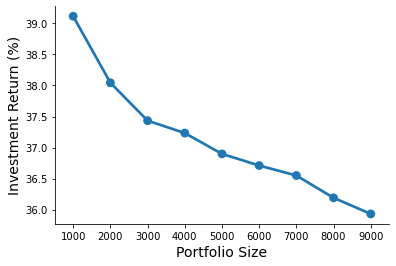

In [43]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict=data_dict,classifier=None,regressor=reg_ridge,strategy='Return-based',num_loans = num_loans,random_state = default_seed,
                        output_to_file = True)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()

**As we can see, the investment return decreases with the increase in portfolio size**